<a href="https://colab.research.google.com/github/anujpatel1761/EECE5644/blob/main/Assignment1/Assignment1_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# -----------------------------------
# Data Loading Functions
# -----------------------------------
def get_wine_details(filepath, display_lines=5):
    """
    Load and display a preview of the Wine Quality dataset. Extracts features,
    target labels, and defines possible quality ratings.

    Parameters:
        filepath (str): Path to the wine quality dataset.
        display_lines (int): How many lines of the dataset to print as a preview.

    Returns:
        tuple: Features (ndarray), target labels (ndarray), possible ratings (ndarray).
    """
    dataset = np.loadtxt(filepath, delimiter=';', skiprows=1)
    features = dataset[:, :-1]  # Extract features (all columns except the last)
    target_labels = dataset[:, -1]  # Extract target labels (the last column)
    possible_ratings = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Define wine quality rating

    # print("Preview of Wine Dataset:")
    # print(dataset[:display_lines])
    # print(f"Dimensions of Wine Dataset: {dataset.shape[0]} rows, {dataset.shape[1]} columns")

    return features, target_labels, possible_ratings

In [4]:
def get_activity_data(test_X_path, test_y_path, train_X_path, train_y_path, display_lines=5):
    """
    Load and display a preview of the Human Activity Recognition dataset. Combines
    testing and training data into single datasets for features and labels.

    Parameters:
        test_X_path (str): Path to the test features file.
        test_y_path (str): Path to the test labels file.
        train_X_path (str): Path to the train features file.
        train_y_path (str): Path to the train labels file.
        display_lines (int): How many lines of the dataset to print as a preview.

    Returns:
        tuple: Activity features (ndarray), activity labels (ndarray), activity categories (ndarray).
    """

    test_features = np.loadtxt(test_X_path)
    test_targets = np.loadtxt(test_y_path)
    train_features = np.loadtxt(train_X_path)
    train_targets = np.loadtxt(train_y_path)

    activity_features = np.concatenate((test_features, train_features), axis=0)
    activity_labels = np.concatenate((test_targets, train_targets), axis=0)
    activity_categories = np.array([1, 2, 3, 4, 5, 6])

    # print("Preview of Activity Recognition Dataset:")
    # print(activity_features[:display_lines])
    # print(f"Dimensions of Activity Dataset: {activity_features.shape[0]} rows, {activity_features.shape[1]} columns")

    return activity_features, activity_labels, activity_categories

In [5]:
# -----------------------------------
# Parameter Estimation Function
# -----------------------------------
def find_param(features, labels):
    """
      Estimates the statistical parameters needed for Gaussian classifier. Calculates
      the mean vectors, covariance matrices, and class probabilities (priors) for each class.

      Parameters:
          features (ndarray): Feature data for the dataset.
          labels (ndarray): Labels corresponding to the features.

      Returns:
          tuple: Categories (unique labels), mean vectors, covariance matrices, class probabilities.
      """
    categories = np.unique(labels)
    mean_vectors = [np.mean(features[labels == cat], axis=0) for cat in categories]
    cov_matrices = [np.cov(features[labels == cat].T) for cat in categories]
    class_probs = [np.mean(labels == cat) for cat in categories]

    return categories, np.array(mean_vectors), np.array(cov_matrices), np.array(class_probs)

In [6]:
# -----------------------------------
# Covariance Regularization Function
# -----------------------------------
def estimation_of_covariance(cov_matrices, dataset_name, print_reg_term=True):
    """
    Regularizes covariance matrices by adding a small value to the diagonal
    elements. This is used to ensure that the matrices are well-conditioned
    and invertible, which is necessary for the Gaussian PDF computation.

    Parameters:
        cov_matrices (list of ndarray): List of covariance matrices for each class.
        dataset_name (str): Name of the dataset for logging purposes.
        print_reg_term (bool): Flag to print the regularization factor.

    Returns:
        list of ndarray: Regularized covariance matrices.
    """
    average_covariance_matrix = np.mean(cov_matrices, axis=0)
    reg_factor = np.median(np.diag(average_covariance_matrix))
    if print_reg_term:
        print(f"The regularization term for {dataset_name} is: {reg_factor}")

    for i in range(len(cov_matrices)):
        cov_matrices[i] += reg_factor * np.eye(cov_matrices[i].shape[0])

    return cov_matrices

In [7]:
# -----------------------------------
# Classification and Evaluation Functions
# -----------------------------------
def minimum_probability_of_error_classifier(data, unique_labels, mean_vectors, cov_matrices, priors):
    """
    Classifies each sample to the class with the highest probability using the
    Gaussian PDFs, computed mean vectors, covariance matrices, and priors.

    Parameters:
        data (ndarray): Dataset to classify.
        unique_labels (ndarray): Array of unique class labels.
        mean_vectors (list of ndarray): Mean vectors for each class.
        cov_matrices (list of ndarray): Covariance matrices for each class.
        priors (list): Prior probabilities for each class.

    Returns:
        ndarray: Predicted labels for each sample in the dataset.
    """
    np.random.seed(7)
    perturbed_priors = priors + np.random.normal(0, 0.01, len(priors))
    classification_probs = np.zeros((data.shape[0], len(unique_labels)))
    for i, label in enumerate(unique_labels):
        classification_probs[:, i] = multivariate_normal.pdf(data, mean_vectors[i], cov_matrices[i]) * perturbed_priors[i]
    highest_prob_indices = np.argmax(classification_probs, axis=1)
    predicted_labels = unique_labels[highest_prob_indices]
    return predicted_labels

In [8]:
def compute_evaluation_metrics(predicted_labels, actual_labels, possible_labels):
    """
    Computes the error count, error probability estimate, and confusion matrix
    for the classification results.

    Parameters:
        predicted_labels (ndarray): Labels predicted by the classifier.
        actual_labels (ndarray): True labels of the data.
        possible_labels (ndarray): All possible labels (for confusion matrix dimension).

    Returns:
        tuple: Error count, error probability estimate, confusion matrix.
    """
    error_count = 0
    correct_count = 0
    total_samples = len(predicted_labels)
    confusion_matrix = np.zeros((len(possible_labels), len(possible_labels)), dtype=int)

    for i in range(len(predicted_labels)):
        if predicted_labels[i] != actual_labels[i]:
            error_count += 1
        actual_index = np.where(possible_labels == actual_labels[i])[0][0]
        predicted_index = np.where(possible_labels == predicted_labels[i])[0][0]
        confusion_matrix[actual_index, predicted_index] += 1

    error_prob_estimate = error_count / len(predicted_labels)
    # Print the total number of misclassified samples and error probability
    print(f"Total Number of Samples: {total_samples}")
    print(f"Misclassified Samples: {error_count}")
    print(f"Probability of Error: {error_prob_estimate:.4f}")
    return error_count, error_prob_estimate, confusion_matrix

In [9]:
def plot_confusion_matrix(conf_matrix, title="Confusion Matrix"):
    """
    Plots the confusion matrix using seaborn's heatmap function.

    Parameters:
        conf_matrix (ndarray): Confusion matrix to be plotted.
        title (str): Title for the confusion matrix plot.
    """
    print("Confusion Matrix:")
    print(np.array2string(conf_matrix, separator=', '))
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [10]:
# -----------------------------------
# Main Processing Functions
# -----------------------------------
def process_dataset(features, labels, parameters):
    """
    Processes the dataset by classifying it and then computing the evaluation metrics.

    Parameters:
        features (ndarray): Feature set of the dataset.
        labels (ndarray): Labels corresponding to the features.
        parameters (tuple): Tuple containing categories, mean vectors, cov matrices, and class probabilities.

    Returns:
        tuple: Metrics from the evaluation (error count, error probability, confusion matrix).
    """
    print("Processing dataset...")
    predicted_labels = minimum_probability_of_error_classifier(features, parameters[0], parameters[1], parameters[2], parameters[3])
    metrics = compute_evaluation_metrics(predicted_labels, labels, np.unique(labels))
    plot_confusion_matrix(metrics[2])
    return metrics

In [11]:
def visualize_pca_wine(wine_features, wine_labels):
    """
    Visualizes the PCA of the wine dataset in 3D, scaled and colored by wine quality.
    Each quality is represented with a different marker.

    Parameters:
        wine_features (ndarray): The features of the wine dataset.
        wine_labels (ndarray): The quality labels of the wine dataset.
    """
    # Standardizing the features
    feature_scaler = StandardScaler()
    scaled_wine_features = feature_scaler.fit_transform(wine_features)

    # Applying PCA to reduce to three dimensions
    pca_model = PCA(n_components=3)
    pca_components = pca_model.fit_transform(scaled_wine_features)

    # Explained variance helps understand the amount of information retained
    print("Explained variance ratio (Wine): ", pca_model.explained_variance_ratio_)

    # Setup the 3D plot
    pca_figure = plt.figure(figsize=(10, 10))
    ax_3d = pca_figure.add_subplot(111, projection='3d')
    quality_levels = np.sort(np.unique(wine_labels))

    # Marker styles for each quality level
    quality_markers = ['o', 's', '^', 'P', '*', 'X', 'D', '<', '>', 'v']

    # Ensure we have enough markers
    if len(quality_levels) > len(quality_markers):
        quality_markers *= int(np.ceil(len(quality_levels) / len(quality_markers)))

    # Plotting each quality with different markers
    for idx, quality in enumerate(quality_levels):
        quality_indices = wine_labels == quality
        num_samples = np.sum(quality_indices)
        ax_3d.scatter(pca_components[quality_indices, 0],
                      pca_components[quality_indices, 1],
                      pca_components[quality_indices, 2],
                      label=f"Quality {quality} (n={num_samples})",
                      marker=quality_markers[idx % len(quality_markers)])

    # Adding labels to axes
    ax_3d.set_xlabel(r"$z_1$", fontsize=10)
    ax_3d.set_ylabel(r"$z_2$", fontsize=10)
    ax_3d.set_zlabel(r"$z_3$", fontsize=10)

    # Setting the title and adjusting plot aesthetics
    ax_3d.set_title("PCA of Wine Dataset", fontsize=10)
    plt.legend(title="Wine Quality", title_fontsize='10', fontsize=10)
    plt.tight_layout()

    # Optional: set aspect ratio based on the data spread in each principal component direction
    ax_3d.set_box_aspect([np.ptp(pca_components[:, i]) for i in range(3)])  # Equal aspect ratio

    plt.show()


In [12]:
def visualize_pca_activity(activity_features, activity_types):
    """
    Visualizes the PCA of the activity dataset in 3D, colored by activity type.
    Each activity type is represented with a different color.

    Parameters:
        activity_features (ndarray): The features of the activity dataset.
        activity_types (ndarray): The activity labels of the dataset.
    """
    # Standardizing the features
    feature_scaler = StandardScaler()
    standardized_features = feature_scaler.fit_transform(activity_features)

    # Applying PCA to reduce to three dimensions
    pca_model = PCA(n_components=3)
    pca_transformed_features = pca_model.fit_transform(standardized_features)

    # Explained variance ratio helps understand the amount of information retained
    print("Explained variance ratio (Activity): ", pca_model.explained_variance_ratio_)

    # Setup the 3D plot
    figure = plt.figure(figsize=(10, 10))
    ax_3d_plot = figure.add_subplot(111, projection='3d')
    unique_activities = np.sort(np.unique(activity_types))

    # Colors for each activity type
    activity_color_map = plt.cm.jet(np.linspace(0, 1, len(unique_activities)))

    # Plotting each activity with different colors
    for i, activity in enumerate(unique_activities):
        activity_type_indices = activity_types == activity
        num_samples_per_activity = np.sum(activity_type_indices)
        ax_3d_plot.scatter(pca_transformed_features[activity_type_indices, 0],
                           pca_transformed_features[activity_type_indices, 1],
                           pca_transformed_features[activity_type_indices, 2],
                           color=activity_color_map[i],
                           label=f"Activity {activity} (n={num_samples_per_activity})")

    # Adding labels to axes
    ax_3d_plot.set_xlabel(r"$z_1$", fontsize=10)
    ax_3d_plot.set_ylabel(r"$z_2$", fontsize=10)
    ax_3d_plot.set_zlabel(r"$z_3$", fontsize=10)

    # Setting the title and adjusting plot aesthetics
    ax_3d_plot.set_title("PCA of HAR Dataset", fontsize=16)
    plt.legend(title="Activity Type", title_fontsize='10', fontsize=11)
    plt.tight_layout()

    # Optional: set aspect ratio based on the data spread in each principal component direction
    ax_3d_plot.set_box_aspect([np.ptp(pca_transformed_features[:, i]) for i in range(3)])  # Equal aspect ratio

    plt.show()


In [13]:
def plot_wine_quality_features(wine_data, quality_scores):
    """
    Visualizes a 3D scatter plot for the Wine Quality dataset focusing on specific chemical properties as a function of wine quality,
    displaying each quality level with the count of samples.

    Parameters:
        wine_data (ndarray): Feature matrix of the wine dataset.
        quality_scores (ndarray): Quality scores of the wine dataset.
    """
    figure = plt.figure(figsize=(10, 10))
    quality_plot = figure.add_subplot(111, projection='3d')

    # Adjust these indices according to the actual order in your dataset
    idx_fixed_acidity = 0  # Example index for 'fixed acidity'
    idx_alcohol = 10       # Example index for 'alcohol'
    idx_ph = 8             # Example index for 'pH'

    sorted_qualities = np.sort(np.unique(quality_scores))
    for quality in sorted_qualities:
        # Filtering data for each quality score
        quality_filter = quality_scores == quality
        sample_count = np.sum(quality_filter)  # Counting samples per quality score

        # Scatter plot for each quality
        quality_plot.scatter(
            wine_data[quality_filter, idx_fixed_acidity],
            wine_data[quality_filter, idx_alcohol],
            wine_data[quality_filter, idx_ph],
            label=f"Quality {quality} (n={sample_count})"
        )

    # Setting labels for the axes
    quality_plot.set_xlabel("Fixed Acidity")
    quality_plot.set_ylabel("Alcohol")
    quality_plot.set_zlabel("pH")

    # Additional plot settings
    plt.title("3D Visualization of Wine Chemical Properties")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage assuming wine_data and quality_scores are loaded:
# plot_wine_quality_features(wine_data, quality_scores)


Starting dataset processing...
The regularization term for Wine Dataset is: 0.024089923537214092
The regularization term for Activity Dataset is: 0.024404817926492753
Processing dataset...
Total Number of Samples: 4898
Misclassified Samples: 2262
Probability of Error: 0.4618
Confusion Matrix:
[[   7,    1,    4,    8,    0,    0,    0],
 [   3,    9,   97,   52,    2,    0,    0],
 [  10,    8,  923,  496,   19,    1,    0],
 [  21,    3,  571, 1367,  236,    0,    0],
 [   2,    0,   89,  461,  323,    4,    1],
 [   2,    0,    8,   86,   74,    5,    0],
 [   0,    0,    0,    1,    2,    0,    2]]


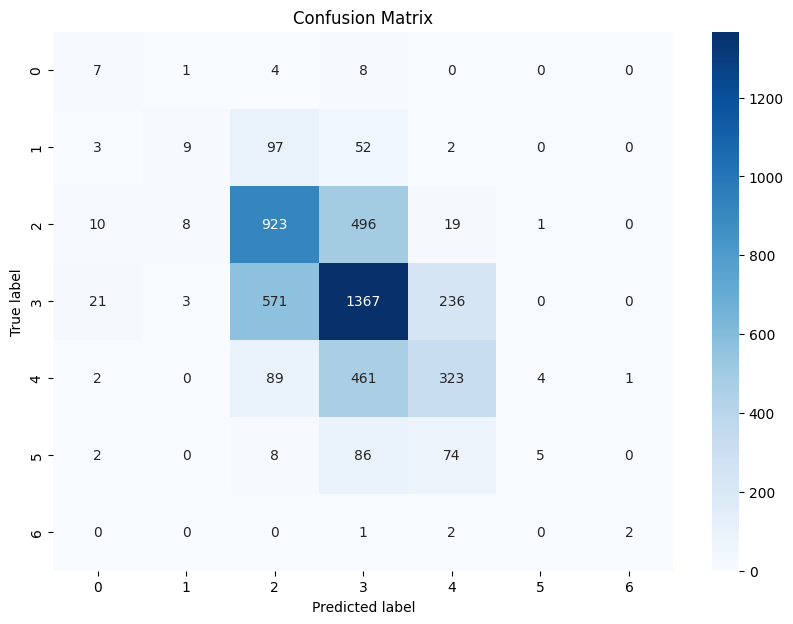

Processing dataset...
Total Number of Samples: 10299
Misclassified Samples: 221
Probability of Error: 0.0215
Confusion Matrix:
[[1718,    3,    1,    0,    0,    0],
 [   0, 1544,    0,    0,    0,    0],
 [   2,   45, 1359,    0,    0,    0],
 [   0,    1,    0, 1615,  161,    0],
 [   0,    0,    0,    8, 1898,    0],
 [   0,    0,    0,    0,    0, 1944]]


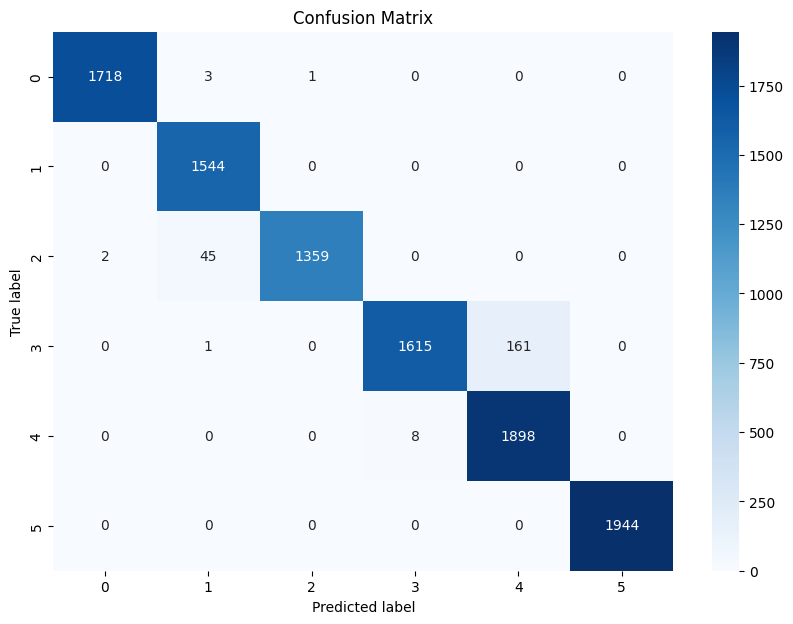

Explained variance ratio (Wine):  [0.29293217 0.14320363 0.11106103]


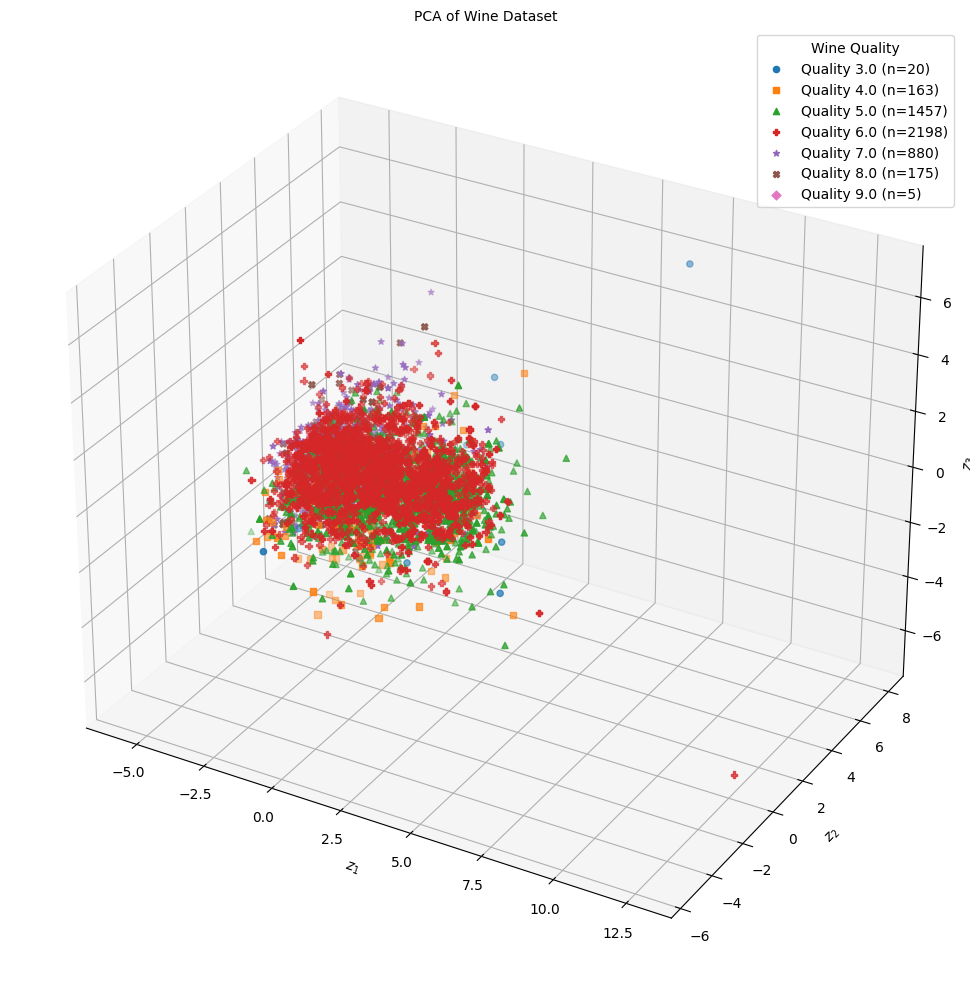

Explained variance ratio (Activity):  [0.50738221 0.06239186 0.02692564]


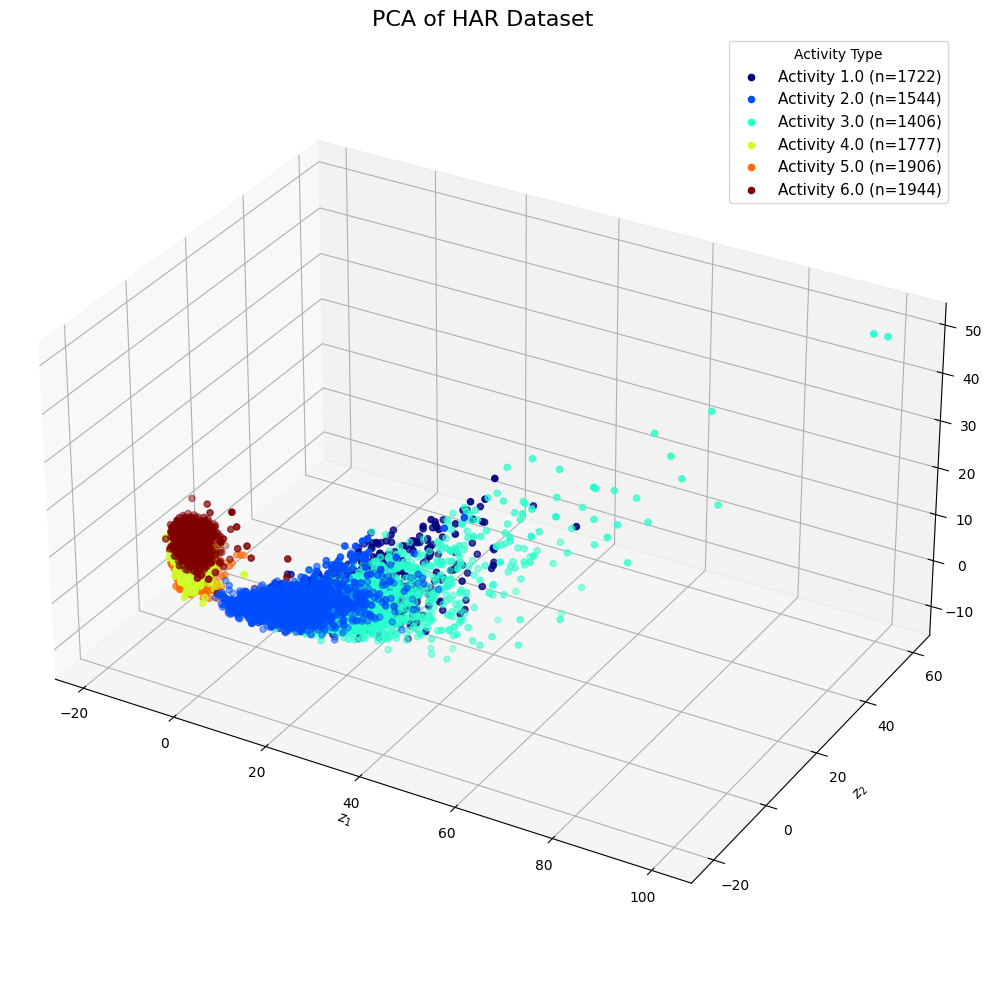

NameError: name 'wine_data' is not defined

In [14]:
print("Starting dataset processing...")
wine_features, wine_lbls, wine_qualities = get_wine_details('/content/drive/MyDrive/Machine_Learning/wine+quality/winequality-white.csv')
activity_features, activity_labels, activity_types = get_activity_data(
    '/content/drive/MyDrive/Machine_Learning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt',
    '/content/drive/MyDrive/Machine_Learning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt',
    '/content/drive/MyDrive/Machine_Learning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt',
    '/content/drive/MyDrive/Machine_Learning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt'
)

# Estimate parameters for wine and activity datasets
wine_parameters = find_param(wine_features, wine_lbls)
activity_parameters = find_param(activity_features, activity_labels)

# Regularize covariance matrices
wine_cov_matrices = estimation_of_covariance(wine_parameters[2], "Wine Dataset")
activity_cov_matrices = estimation_of_covariance(activity_parameters[2], "Activity Dataset")

# Process datasets and compute metrics
wine_metrics = process_dataset(wine_features, wine_lbls, wine_parameters)
activity_metrics = process_dataset(activity_features, activity_labels, activity_parameters)

# Visualize PCA results
visualize_pca_wine(wine_features, wine_lbls)
visualize_pca_activity(activity_features, activity_labels)

plot_wine_quality_features(wine_features, wine_lbls)
